# Large-scale models and simulation methods - Project

## Data:

[INSEE CENSUS](https://www.insee.fr/fr/statistiques/fichier/6544333/RP2019_INDCVIZB_csv.zip)

[IGN](https://data.geopf.fr/telechargement/download/CONTOURS-IRIS/CONTOURS-IRIS_2-1__SHP__FRA_2021-01-01/CONTOURS-IRIS_2-1__SHP__FRA_2021-01-01.7z)

[INSEE AGGREGATED](https://www.insee.fr/fr/statistiques/fichier/6543200/base-ic-evol-struct-pop-2019_csv.zip)

[URSSAF](https://open.urssaf.fr/api/explore/v2.1/catalog/datasets/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B)


In [1]:
from pathlib import Path
import pandas as pd
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sys import exit
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = Path("./data/")
CENSUS_DATA = DATA_FOLDER / "FD_INDCVIZB_2019.csv"
IRIS_DATA = DATA_FOLDER / "CONTOURS-IRIS.shp"
POULATION_DATA = DATA_FOLDER / "base-ic-evol-struct-pop-2019.CSV"
EMPLOYMENT_DATA = (
    DATA_FOLDER
    / "etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv"
)

print("DATA_FOLDER:", DATA_FOLDER)

if not DATA_FOLDER.exists():
    print("Creating data folder")
    DATA_FOLDER.mkdir()
if not CENSUS_DATA.exists():
    print(f"CENSUS data is missing! Please add: {CENSUS_DATA}")
    exit()
if not IRIS_DATA.exists():
    print(f"IRIS data is missing! Please add: {IRIS_DATA}")
    exit()
if not POULATION_DATA.exists():
    print(f"POPULATION data is missing! Please add: {POULATION_DATA}")
    exit()
if not EMPLOYMENT_DATA.exists():
    print(f"EMPLOYMENT data is missing! Please add: {EMPLOYMENT_DATA}")
    exit()

DATA_FOLDER: data


In [3]:
# Census data

columns = {
    "IRIS": str,
    "IPONDI": float,
    "AGED": int,
    "CS1": int,
    "DEPT": int,
}
df_census = pd.read_csv(CENSUS_DATA, sep=";", dtype=columns, usecols=columns.keys())
df_census = df_census.rename(
    columns={
        "IRIS": "iris_id",
        "IPONDI": "weight",
        "AGED": "age",
        "CS1": "csp",
        "DEPT": "department",
    }
)
df_census = df_census[df_census["department"] == 28]
df_census = df_census.drop(columns=["department"])

df_census["department_id"] = df_census["iris_id"].str[:2]
df_census["municipality_id"] = df_census["iris_id"].str[:5]

municiplaities_in_department = df_census["municipality_id"].unique()

print(df_census.head())
print(df_census.describe())
print(df_census.info())

        age  csp    weight    iris_id department_id municipality_id
818102   25    5  4.930477  ZZZZZZZZZ            ZZ           ZZZZZ
818103   52    4  4.930477  ZZZZZZZZZ            ZZ           ZZZZZ
818104   60    2  4.930477  ZZZZZZZZZ            ZZ           ZZZZZ
818105   74    7  4.930477  ZZZZZZZZZ            ZZ           ZZZZZ
818106   53    5  5.016507  ZZZZZZZZZ            ZZ           ZZZZZ
                 age            csp         weight
count  110345.000000  110345.000000  110345.000000
mean       41.756156       6.195958       3.911953
std        24.588907       1.761282       1.362755
min         0.000000       1.000000       0.058374
25%        20.000000       5.000000       2.866920
50%        42.000000       7.000000       4.890710
75%        61.000000       8.000000       5.022492
max       116.000000       8.000000       8.170104
<class 'pandas.core.frame.DataFrame'>
Index: 110345 entries, 818102 to 928446
Data columns (total 6 columns):
 #   Column           N

In [4]:
# Iris data

df_iris: gpd.GeoDataFrame = gpd.read_file(IRIS_DATA)
df_iris = df_iris.rename(
    columns={
        "INSEE_COM": "municipality_id",
        "CODE_IRIS": "iris_id",
    }
)[["iris_id", "municipality_id", "geometry"]]
df_iris["department_id"] = df_iris["iris_id"].str[:2]

print(df_iris.head())

     iris_id municipality_id  \
0  721910000           72191   
1  772480000           77248   
2  514260000           51426   
3  811990000           81199   
4  592250102           59225   

                                            geometry department_id  
0  POLYGON ((498083.5 6747517.4, 498128 6747467.1...            72  
1  POLYGON ((685753.1 6868612.9, 685757.7 6868592...            77  
2  POLYGON ((759067.2 6849592.7, 758778.6 6849650...            51  
3  POLYGON ((651482.8 6326359.4, 651475.6 6326359...            81  
4  POLYGON ((767673.5 7022290.5, 767647.2 7022275...            59  


In [5]:
# Population data

columns = ["COM", "C19_POP15P"]
columns += ["C19_POP15P_CS{}".format(k) for k in range(1, 9)]

df_population = pd.read_csv(
    POULATION_DATA,
    sep=";",
    usecols=columns,
    dtype={"COM": str},
)

renamed_columns = ["municipality_id", "population"]
renamed_columns += ["csp_{}".format(k) for k in range(1, 9)]
df_population.columns = renamed_columns

df_population = df_population.groupby("municipality_id").sum().reset_index()

df_population = df_population[
    df_population["municipality_id"].isin(municiplaities_in_department)
]

print(df_population.head())
print(df_population.describe())
print(df_population.info())

      municipality_id    population      csp_1       csp_2        csp_3  \
9998            28085  32004.085445  61.455663  767.719844  3575.409814   
10001           28088  10861.929390  35.197159  200.777769   386.038780   
10039           28134  23504.608739  21.815211  545.824080  1227.835949   
10112           28218  12528.595777   7.810856  215.456539   533.032374   
10114           28220   5580.782426  20.062861  155.418605   626.005713   

             csp_4        csp_5        csp_6        csp_7        csp_8  
9998   4638.895910  5039.420821  3709.700067  9134.975008  5076.508317  
10001   994.686264  1518.759287  1641.451699  3603.530410  2481.488023  
10039  2468.348230  4098.255072  4002.284907  5481.098564  5659.146727  
10112  1614.482616  2533.311706  2072.046550  3718.426362  1834.028774  
10114   917.372331   756.975838   501.113224  1889.575332   714.258523  
         population      csp_1       csp_2        csp_3        csp_4  \
count      8.000000   8.000000    8.000

In [6]:
# Employment data

df_employment = pd.read_csv(
    EMPLOYMENT_DATA,
    sep=";",
    usecols=["Code commune", "Effectifs salariés 2019"],
    dtype={"Code commune": str},
)

df_employment = df_employment.rename(
    columns={"Code commune": "municipality_id", "Effectifs salariés 2019": "employment"}
)

df_employment = df_employment.groupby("municipality_id").sum().reset_index()

df_employment = df_employment[
    df_employment["municipality_id"].isin(municiplaities_in_department)
]

print(df_employment.head())
print(df_employment.describe())
print(df_employment.info())

     municipality_id  employment
9509           28085     20062.0
9512           28088      4103.0
9550           28134      8373.0
9622           28218      3963.0
9624           28220      1738.0
         employment
count      8.000000
mean    6010.875000
std     6006.824201
min     1738.000000
25%     3196.750000
50%     3954.000000
75%     5170.500000
max    20062.000000
<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 9509 to 9778
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   municipality_id  8 non-null      object 
 1   employment       8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 192.0+ bytes
None


## Exercise 1.1: Study area


### (1) How many person observations are included in the census for that department?


In [7]:
observations = len(df_census)
print(f"Number of observations: {observations}")

Number of observations: 110345


### (2) How many persons live in that department?


In [8]:
people = df_census["weight"].sum()
print(f"Number of people: {people}")

Number of people: 431664.40641548834


### (3) How many municipalities are there in the department?


In [9]:
print(f"Municipalities: {municiplaities_in_department}")
print(f"Number of municipalities: {municiplaities_in_department.size}")

Municipalities: ['ZZZZZ' '28229' '28088' '28404' '28218' '28220' '28280' '28085' '28134']
Number of municipalities: 9


### Prepare a map that shows where the department is located inside of France.


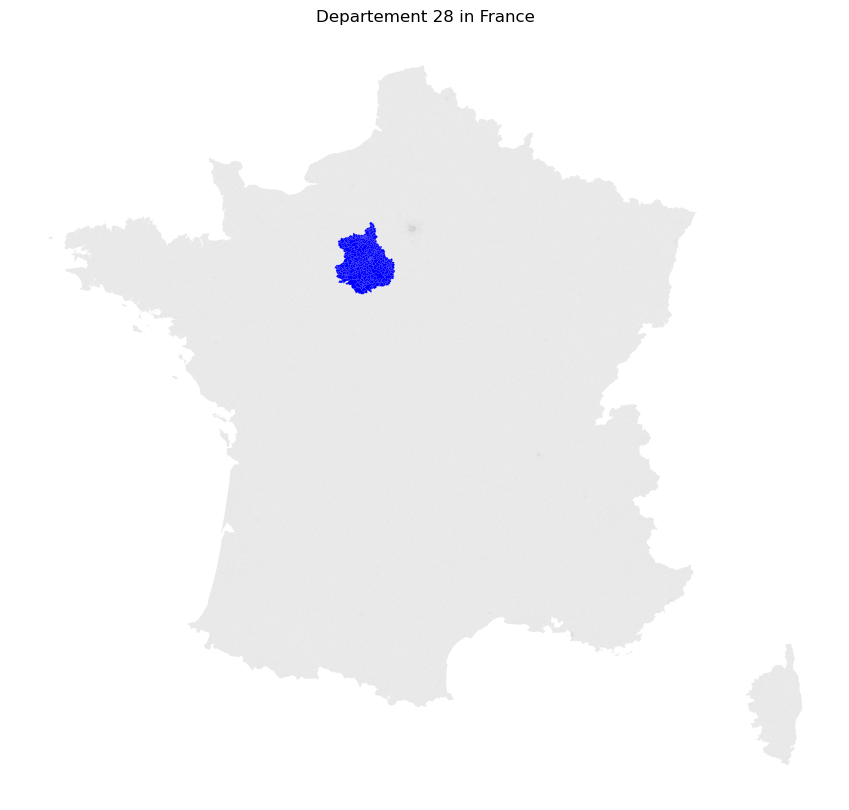

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
df_iris.plot(ax=ax, color="lightgrey", alpha=0.5)
df_iris[df_iris["department_id"] == "28"].plot(
    ax=ax,
    color="blue",
)

ax.set_title("Departement 28 in France")
ax.axis("off")

plt.show()

## Exercise 1.2: Territorial analysis I


### Plot the age distribution of the persons living in the department. Indicate the average age of persons living in the territory.


In [11]:
weighted_counts = (
    df_census.groupby("age")["weight"]
    .sum()
    .reset_index()
    .rename(columns={"weight": "weighted_count"})
)

weighted_avg_age = (
    weighted_counts["age"] * weighted_counts["weighted_count"]
).sum() / weighted_counts["weighted_count"].sum()

fig = px.bar(
    weighted_counts,
    x="age",
    y="weighted_count",
    title="Age Distribution",
)
fig.add_vline(
    x=weighted_avg_age,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Avg. age: {weighted_avg_age:.2f}",
    annotation_position="top",
)
fig.show()

print(f"Avg. age: {weighted_avg_age:.2f}")

Avg. age: 42.38


### Make a map of the municipalities in the study area and indicate the average age of their population. Which municipality is the youngest, which one is the oldest?


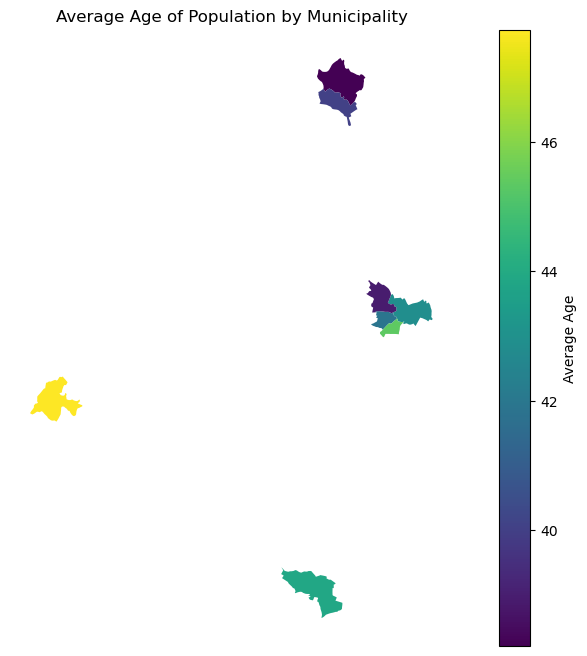

Youngest Municipality: ID 28134 with Avg Age 38.21
Oldest Municipality: ID 28280 with Avg Age 47.73


In [12]:
spatial_municipalities = df_iris.dissolve(by="municipality_id").reset_index()

df_census_grouped = (
    df_census.groupby("municipality_id")
    .apply(
        lambda x: pd.Series(
            {
                "total_weight": x["weight"].sum(),
                "avg_age": (
                    (x["age"] * x["weight"]).sum() / x["weight"].sum()
                    if x["weight"].sum() > 0
                    else 0
                ),
            }
        )
    )
    .reset_index()
)

spatial_data = spatial_municipalities.merge(
    df_census_grouped, on="municipality_id", how="left"
)

fig, ax = plt.subplots(figsize=(12, 8))
spatial_data.plot(
    column="avg_age",
    cmap="viridis",
    legend=True,
    ax=ax,
    legend_kwds={"label": "Average Age"},
)
ax.set_title("Average Age of Population by Municipality")
ax.set_axis_off()

plt.show()

youngest = spatial_data.loc[spatial_data["avg_age"].idxmin()]
oldest = spatial_data.loc[spatial_data["avg_age"].idxmax()]
print(
    f"Youngest Municipality: ID {youngest['municipality_id']} with Avg Age {youngest['avg_age']:.2f}"
)
print(
    f"Oldest Municipality: ID {oldest['municipality_id']} with Avg Age {oldest['avg_age']:.2f}"
)

### Plot the distribution of socio-professional categories of the overall study area and for at least three individual municipalities. Describe if you see differences between municipalities and the study area in general.


In [13]:
def plot_csp_distribution(df_census: pd.DataFrame, title: str = "CSP Distribution"):
    df_csp = df_census.groupby("csp")["weight"].sum().reset_index()

    df_csp["csp"] = df_csp["csp"].replace(
        {
            1: "Agriculteurs",
            2: "Artisans",
            3: "Cadres",
            4: "Intermédiaires",
            5: "Employés",
            6: "Ouvriers",
            7: "Retraités",
            8: "Autres",
        }
    )

    fig = px.histogram(df_csp, x="csp", y="weight", title=title).update_xaxes(
        categoryorder="total descending"
    )
    fig.show()


plot_csp_distribution(
    df_census,
    title="CSP Distribution - Departement '28'",
)
for municipality_id in df_census["municipality_id"].unique():
    plot_csp_distribution(
        df_census[df_census["municipality_id"] == municipality_id],
        title=f"CSP Distribution - Municipality '{municipality_id}'",
    )

## Exercise 1.3: Territorial analysis II


### Create a bar plot indicating the number of working inhabitants in each municipality.


In [14]:
working_csp = [1, 2, 3, 4, 5, 6]
df_working = df_census[df_census["csp"].isin(working_csp)]

working_by_municipality = (
    df_working.groupby("municipality_id")["weight"]
    .sum()
    .reset_index()
    .rename(columns={"weight": "working_population"})
)

fig = px.bar(
    working_by_municipality,
    x="municipality_id",
    y="working_population",
    title="Working Population by Municipality",
).update_xaxes(categoryorder="total descending")
fig.show()

### Create a bar plot indicating the number of employees in each municipality


In [15]:
fig = px.bar(
    df_employment,
    x="municipality_id",
    y="employment",
    title="Number of Employees by Municipality",
).update_xaxes(categoryorder="total descending")
fig.show()

### Make a map of the study area which, for each municipality, shows the difference between working inhabitants and employees. Which municipality the largest net outflow (inhabitants - employees), which one the largest net inflow of employees?


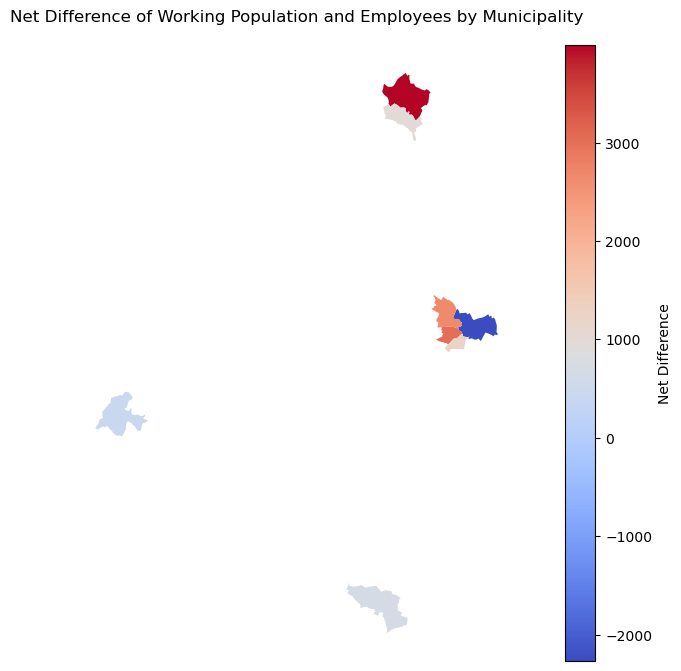

Largest Deficit Municipality: ID 28085 with Net Difference -2266.6100506216026
Largest Surplus Municipality: ID 28134 with Net Difference 3991.363449044109


In [16]:
df_combined = df_employment.merge(working_by_municipality, on="municipality_id")
df_combined["net_difference"] = (
    df_combined["working_population"] - df_combined["employment"]
)

spatial_data = spatial_municipalities.merge(
    df_combined, on="municipality_id", how="left"
)
fig, ax = plt.subplots(figsize=(12, 8))
spatial_data.plot(
    column="net_difference",
    cmap="coolwarm",
    legend=True,
    ax=ax,
    legend_kwds={"label": "Net Difference"},
)
ax.set_title("Net Difference of Working Population and Employees by Municipality")
ax.set_axis_off()

plt.show()

largest_deficit = spatial_data.loc[spatial_data["net_difference"].idxmin()]
largest_surplus = spatial_data.loc[spatial_data["net_difference"].idxmax()]

print(
    f"Largest Deficit Municipality: ID {largest_deficit['municipality_id']} with Net Difference {largest_deficit['net_difference']}"
)
print(
    f"Largest Surplus Municipality: ID {largest_surplus['municipality_id']} with Net Difference {largest_surplus['net_difference']}"
)

## Exercise 2.1: Trip production

### Apply the model to your study area and solve the following tasks:


### Report how many trips have been generated in total.


### Report using a bar plot how many trips have been generated for each SPC in the study area.


### On a map, show the total number of trips generated per IRIS.


## Exercise 2.2: Trip attraction


### Report on the value of N that you have chosen. Plot on a map how many arriving trips have been generated for each municipality in the study area.


### Proportionately scale your demand per zone from Exercise 2.1


## Exercise 2.3: Trip distribution


### Show the distance matrix as a table or in a plot.


### Report the resulting flows in a table or plot.


### Document the 10 pairs of municipalities with the largest flows and name them.


## Exercise 3.1: Disaggregation


### Plot the generated trip pairs on a map using a line between origin and destination.


### Plot the distribution of the departure times as a histogram or CDF.


## Exercise 3.2: Routin


### Convert a road network from OpenStreetMap data such that you can use it for routing. Plot the network on a map of your study area.


### Perform a routing of all generated trips on the network. Count the number of trips traversing each edge of your network and indicate the flow on each link on a map.
